# Implementation of the ranking algorithm: LambdaRank

Import the necessary libraries. In this notebook, during model training, gradients will be calculated using the automatic differentiation library [Autograd](https://github.com/HIPS/autograd?tab=readme-ov-file).

In [1]:
import autograd.numpy as np
from autograd import jacobian
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ndcg_score
import warnings
warnings.filterwarnings("ignore")

We will use part of the dataset "Microsoft Learning to Rank Datasets": MSLR-WEB10K-Fold1-vali.txt. 

The dataset consists of feature vectors extracted from query-url pairs along with relevance judgment labels. Queries and urls are represented by IDs. The relevance judgments are obtained from a retired labeling set of a commercial web search engine (Microsoft Bing), which take 5 values from 0 (irrelevant) to 4 (perfectly relevant). In the data files, each row corresponds to a query-url pair. The first column is relevance label of the pair, the second column is query id, and the following columns are features. The larger value the relevance label has, the more relevant the query-url pair is. A query-url pair is represented by a 136-dimensional feature vector.

In [2]:
df = pd.read_csv('data/MSLR-WEB.txt', header=None, sep=' ')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,0,qid:28,1:2,2:0,3:1,4:0,5:2,6:1,7:0,8:0.50000,...,128:7,129:0,130:119,131:1112,132:7,133:3,134:0,135:0,136:0,NaN
1,3,qid:28,1:2,2:1,3:2,4:1,5:2,6:1,7:0.50000,8:1,...,128:1,129:0,130:153,131:845,132:7,133:121,134:0,135:0,136:0,NaN
2,3,qid:28,1:2,2:0,3:2,4:1,5:2,6:1,7:0,8:1,...,128:4,129:1,130:154,131:236,132:104,133:153,134:0,135:0,136:0,NaN
3,0,qid:28,1:1,2:0,3:0,4:0,5:1,6:0.50000,7:0,8:0,...,128:34,129:2,130:289,131:57044,132:1,133:6,134:0,135:4,136:78.1,NaN
4,0,qid:28,1:2,2:0,3:1,4:1,5:2,6:1,7:0,8:0.50000,...,128:0,129:0,130:1539,131:55499,132:1,133:1,134:0,135:0,136:0,NaN


In [3]:
df.shape

(47001, 139)

Let's find columns with missing values.

In [4]:
print('columns where all data is missing:', df.columns[df.isna().all()].tolist())
print('columns that have missing data:', df.columns[df.isna().any()].tolist())

columns where all data is missing: [138]
columns that have missing data: [138]


Removing column 138 containing None. Removing the names **feature_id:** and **qid:** from the data. Replacing the column names with more informative ones. And converting data type from object to int and float.

In [5]:
def preprocess_data(df):
    df[1] = df[1].apply(lambda col: col[4:])
    df.iloc[:, 2:138] = df.iloc[:, 2:138].applymap(lambda col: col.split(':')[1])
    df = df.drop(columns=[138])
    df.columns = ['feat_' + str(i-1) for i in df.columns]
    df.rename(columns={'feat_-1': 'relevance', 'feat_0': 'qid'}, inplace=True)
    df.iloc[:, 2:138] = df.iloc[:, 2:138].astype(float)
    df.iloc[:, 0:2] = df.iloc[:, 0:2].astype(int)
    return df

In [6]:
df_prep = preprocess_data(df)
df_prep.head()

,relevance,qid,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_127,feat_128,feat_129,feat_130,feat_131,feat_132,feat_133,feat_134,feat_135,feat_136
0,0,28,2.0,0.0,1.0,0.0,2.0,1.0,0.0,0.5,...,49.0,7.0,0.0,119.0,1112.0,7.0,3.0,0.0,0.0,0.0
1,3,28,2.0,1.0,2.0,1.0,2.0,1.0,0.5,1.0,...,38.0,1.0,0.0,153.0,845.0,7.0,121.0,0.0,0.0,0.0
2,3,28,2.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,...,29.0,4.0,1.0,154.0,236.0,104.0,153.0,0.0,0.0,0.0
3,0,28,1.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,...,38.0,34.0,2.0,289.0,57044.0,1.0,6.0,0.0,4.0,78.1
4,0,28,2.0,0.0,1.0,1.0,2.0,1.0,0.0,0.5,...,42.0,0.0,0.0,1539.0,55499.0,1.0,1.0,0.0,0.0,0.0


In [7]:
df_prep.dtypes.value_counts()

float64    136
int32        2
dtype: int64

To train the model faster, we will use only part of the data, with the number of queries equal to **subset_size**.

In [8]:
queries = df_prep['qid'].unique()
subset_size = 160
queries_subset = np.random.choice(queries, size=subset_size, replace=False)
train_queries, test_queries = train_test_split(queries_subset, test_size=0.35, random_state=42)
train_df = df_prep[df_prep['qid'].isin(train_queries)]
test_df = df_prep[df_prep['qid'].isin(test_queries)]

In [9]:
def get_x_y(df, query):
    df_query = df[df['qid'] == query]
    X_query = np.array(df_query.drop(columns=['relevance', 'qid']))
    y_query = np.array(df_query['relevance'])
    return X_query, y_query

In [10]:
def delete_equal_relevance(df):
    all_queries = df['qid'].unique()
    query_equal_rel = []
    for query in all_queries:
        _, y_query = get_x_y(df, query)
        if np.all(y_query == y_query[0]):
            query_equal_rel.append(query)
    return df.drop(df[df['qid'].isin(query_equal_rel)].index)

If for a given query all relevancies are equal, then we will remove such queries, since they do not contain a useful signal.

In [11]:
train_df = delete_equal_relevance(train_df)
test_df = delete_equal_relevance(test_df)

Let's standardize the data to train the model faster.

In [12]:
scaler = StandardScaler()
train_df.iloc[:,2:138] = scaler.fit_transform(train_df.iloc[:,2:138])
test_df.iloc[:,2:138] = scaler.transform(test_df.iloc[:,2:138])

Select only the most relevant features using Random Forest Regressor.

Let's look at the balance of relevance scores.

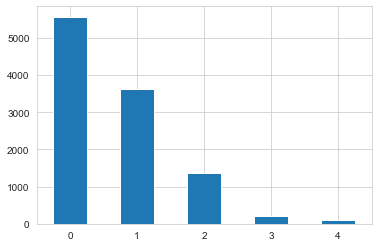

In [13]:
train_df['relevance'].value_counts().plot.bar(rot=0);

In [14]:
queries = train_df['qid'].unique()
train_queries, test_queries = train_test_split(queries, test_size=0.3, random_state=42)
train_df_fs = train_df[train_df['qid'].isin(train_queries)]
test_df_fs = train_df[train_df['qid'].isin(test_queries)]
X_train = train_df_fs.drop(['relevance', 'qid'], axis=1)
y_train = train_df_fs['relevance']
X_test = test_df_fs.drop(['relevance', 'qid'], axis=1)
y_test_df = test_df_fs[['relevance', 'qid']]

In [15]:
def ndcg_mean(y_test_df, y_pred):
    queries_test = y_test_df['qid'].unique()
    num_queries = len(queries_test)
    ndcg = np.zeros(num_queries)
    init_idx = 0
    for i, query in enumerate(queries_test):
        y_test_query = y_test_df[y_test_df['qid'] == query]
        y_test = np.array(y_test_query['relevance'])
        final_idx = init_idx + len(y_test)
        score = y_pred[init_idx: final_idx]
        init_idx = final_idx
        ndcg[i] = ndcg_score(y_test[None, :], score[None, :])
    return np.mean(ndcg)

Let's try to find the most optimal parameters for training the Random Forest Regressor. NDCG will be used as a quality metric.

In [16]:
n_estimators = [50]
max_features = [40, 45, 50]
min_samples_leaf = [4, 5, 6]

param_grid = [
    {
        'n_estimators': ne,
        'max_features': mf, 
        'min_samples_leaf': msl,
        'random_state': 42
    } for ne in n_estimators for mf in max_features for msl in min_samples_leaf
]

In [17]:
best_ndcg = 0
best_params = None
for p in tqdm(param_grid):
    rf = RandomForestRegressor(**p)
    rf.fit(X_train, y_train);
    y_pred = rf.predict(X_test)
    ndcg = ndcg_mean(y_test_df, y_pred)
    if best_ndcg < ndcg:
        best_ndcg = ndcg
        best_params = p

  0%|          | 0/9 [00:00<?, ?it/s]

In [18]:
print('best_ndcg:', best_ndcg)
print('best_params:', best_params)

best_ndcg: 0.8009936840992048
best_params: {'n_estimators': 50, 'max_features': 50, 'min_samples_leaf': 6, 'random_state': 42}


In [19]:
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train);

In [20]:
feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importances_sort = feature_importance_df['Importance'].to_list()

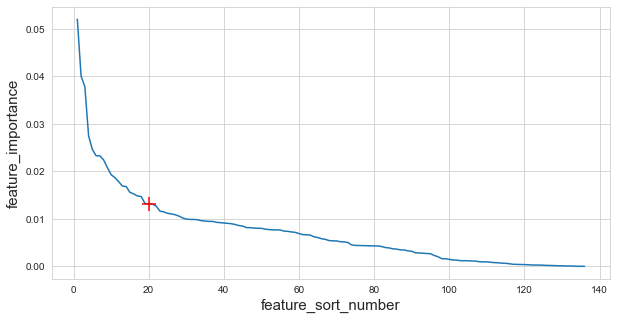

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(np.arange(len(feature_importances_sort)) + 1, feature_importances_sort, zorder=1)
num_features = 20
plt.scatter(num_features, feature_importances_sort[num_features-1], c='r', marker='+', s=200, zorder=2)
plt.xlabel('feature_sort_number', fontsize=15)
plt.ylabel('feature_importance', fontsize=15)
plt.show()

In [22]:
top_features = feature_importance_df.head(num_features)['Feature'].values
top_features

array(['feat_130', 'feat_55', 'feat_131', 'feat_110', 'feat_11',
       'feat_15', 'feat_127', 'feat_129', 'feat_88', 'feat_134',
       'feat_106', 'feat_128', 'feat_132', 'feat_109', 'feat_113',
       'feat_108', 'feat_133', 'feat_123', 'feat_20', 'feat_65'],
      dtype=object)

In [23]:
train_df_selected = train_df[np.append(['relevance', 'qid'], top_features)]
test_df_selected = test_df[np.append(['relevance', 'qid'], top_features)]

LambdaRank is a ranking method based on the pairwise approach. The key observation of LambdaRank is thus that in order to train a model, we don’t need the costs themselves: we only need the gradients (of the costs with respect to the model scores). Such a model actually optimizes NDCG directly.

References:  
- [From RankNet to LambdaRank to LambdaMART: AnOverview](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf).  
- [Learning to Rank with Nonsmooth Cost Functions](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/lambdarank.pdf).

In [24]:
class RankNet():
    def __init__(self, size_0, size_1, size_2):
        std_1 = np.sqrt(2 / size_0)
        self.w1 = np.random.randn(size_0, size_1) * std_1
        self.b1 = np.random.randn(1, size_1) * std_1
        std_2 = np.sqrt(2 / size_1)
        self.w2 = np.random.randn(size_1, size_2) * std_2
        self.b2 = np.random.randn(1, size_2) * std_2
        std_3 = np.sqrt(2 / (size_1 + size_2))
        self.w3 = np.random.randn(size_2, 1) * std_3
        self.b3 = np.random.randn(1, 1) * std_3

    def Leaky_ReLU(self, x):
        return np.maximum(0.01 * x, x)

    def tanh(self, x):
        return 2 / (1 + np.exp(-2 * x)) - 1

    def forward(self, X, w1, b1, w2, b2, w3, b3):
        z1 = self.Leaky_ReLU(np.dot(X, w1) + b1)
        z2 = self.Leaky_ReLU(np.dot(z1, w2) + b2)
        z3 = self.tanh(np.dot(z2, w3) + b3)
        return z3

    def get_x_y(self, df, query):
        df_query = df[df['qid'] == query]
        X_query = np.array(df_query.drop(columns=['relevance', 'qid']))
        y_query = np.array(df_query['relevance'])
        return X_query, y_query

    def jacobian_func(self):
        """
        Compute the Jacobian matrices from the model output given the model coefficients.
        """
        J = []
        for i in range(1,7):
            J.append(jacobian(self.forward, i))
        return J

    def idcg(self, y_true, k):
        """
        Compute the IDCG value

        Parameters
        ----------
        y_true : ndarray of shape (n_samples,)
        k : particular rank position
        """
        position = min(k, len(y_true))
        y_true_sorted = -np.sort(-y_true)[:position]
        gains = np.power(2, y_true_sorted)
        discounts = np.log2(np.arange(position) + 2)
        idcg = gains / discounts
        return np.sum(idcg)

    def ndcg(self, y_true, scores, idcg, k):
        """
        Compute the NDCG value

        Parameters
        ----------
        y_true : ndarray of shape (n_samples,)
        scores : ndarray of shape (n_samples, 1)
        idcg : IDCG value based on the given y_true
        k : particular rank position
        """
        scores = np.squeeze(scores)
        position = min(k, len(y_true))
        argsort_indices = np.argsort(-scores)[:position]
        gains = np.power(2, y_true[argsort_indices])
        discounts = np.log2(np.arange(position) + 2)
        dcg = gains / discounts
        return np.sum(dcg / idcg)

    def calc_lambda_coeff(self, scores, y_true, alpha):
        """
        Compute the NDCG value

        Parameters
        ----------
        y_true : ndarray of shape (n_samples,)
        scores : ndarray of shape (n_samples, 1)
        alpha : parameter that determines the shape of the sigmoid

        Returns
        -------
        lambda_coeff : ndarray of shape (n_samples, 1)
            gradients of the cost function with respect to the model scores
        """
        n_samples = len(y_true)
        idcg = self.idcg(y_true, n_samples)

        y_true = y_true[:,None]
        rel_diff = y_true - y_true.T
        pos_pairs = (rel_diff > 0).astype(int)
        neg_pairs = (rel_diff < 0).astype(int)
        s_ij = pos_pairs - neg_pairs

        rank_order = np.argsort(np.argsort(scores, axis=0), axis=0)
        gains_diff = np.power(2, y_true) - np.power(2, y_true.T)
        discounts_diff = 1 / np.log2(rank_order + 2) - 1 / np.log2(rank_order.T + 2)
        delta_ndcg = np.abs(gains_diff * discounts_diff) / idcg

        lambda_coeff = (
            alpha * ((1 - s_ij) / 2 - 1 / (1 + np.exp(alpha * (scores - scores.T)))) * delta_ndcg
        )
        lambda_coeff = np.sum(lambda_coeff, axis=1)
        return lambda_coeff[:, None]

    def adam_update(self, grad, m, v, lr, beta1=0.9, beta2=0.99, epsilon=1e-8):
        param = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]
        for i in range(6):
            m[i] = beta1 * m[i] + (1 - beta1) * grad[i]
            v[i] = beta2 * v[i] + (1 - beta2) * np.power(grad[i], 2)
            param[i] -= lr * m[i] / (np.sqrt(v[i]) + epsilon)
        return m, v

    def train(self, df, df_test, size_mini_batch, alpha, n_epoch, learning_rate, k):
        all_queries = df['qid'].unique()
        n_queries = all_queries.shape[0]
        ndcg_train_log = np.zeros(n_epoch)
        ndcg_test_log = np.zeros(n_epoch)
        num_batches = n_queries // size_mini_batch
        if n_queries % size_mini_batch != 0:
            num_batches += 1

        m = [np.zeros(self.w1.shape), np.zeros(self.b1.shape), np.zeros(self.w2.shape),
            np.zeros(self.b2.shape), np.zeros(self.w3.shape), np.zeros(self.b3.shape)]
        v = [np.zeros(self.w1.shape), np.zeros(self.b1.shape), np.zeros(self.w2.shape),
            np.zeros(self.b2.shape), np.zeros(self.w3.shape), np.zeros(self.b3.shape)]
        J = self.jacobian_func()
        
        for i in tqdm(range(n_epoch)):
            np.random.shuffle(all_queries)
            for batch in range(num_batches):
                dw1 = np.zeros(self.w1.shape)
                db1 = np.zeros(self.b1.shape)
                dw2 = np.zeros(self.w2.shape)
                db2 = np.zeros(self.b2.shape)
                dw3 = np.zeros(self.w3.shape)
                db3 = np.zeros(self.b3.shape)
                init = batch * size_mini_batch
                final = init + size_mini_batch
                queries_batch = all_queries[init : final]
                for query in queries_batch:
                    X, y = self.get_x_y(df, query)
                    scores = self.forward(X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    lambda_coeff = self.calc_lambda_coeff(scores, y, alpha)
                    jw1 = J[0](X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    jb1 = J[1](X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    jw2 = J[2](X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    jb2 = J[3](X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    jw3 = J[4](X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    jb3 = J[5](X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
                    dw1 += np.tensordot(lambda_coeff, jw1)
                    db1 += np.tensordot(lambda_coeff, jb1)
                    dw2 += np.tensordot(lambda_coeff, jw2)
                    db2 += np.tensordot(lambda_coeff, jb2)
                    dw3 += np.tensordot(lambda_coeff, jw3)
                    db3 += np.tensordot(lambda_coeff, jb3)
                g = [dw1, db1, dw2, db2, dw3, db3]
                m, v = self.adam_update(g, m, v, lr=learning_rate)
            if i % 10 == 0:
                learning_rate *= 0.75
            ndcg_train_log[i] = self.predict(df)
            ndcg_test_log[i] = self.predict(df_test)
        return ndcg_train_log, ndcg_test_log

    def predict(self, df):
        """
        Predict the NDCG for given dataset
        """
        all_queries = df['qid'].unique()
        n_queries = all_queries.shape[0]
        ndcg_all_q = 0
        for query in all_queries:
            X, y_true = self.get_x_y(df, query)
            n_samples = y_true.shape[0]
            scores = self.forward(X, self.w1, self.b1, self.w2, self.b2, self.w3, self.b3)
            idcg = self.idcg(y_true, n_samples)
            ndcg_all_q += self.ndcg(y_true, scores, idcg, n_samples)
        return ndcg_all_q / n_queries

In [25]:
all_queries = train_df_selected['qid'].unique()
n_queries = all_queries.shape[0]
n_features = train_df_selected.shape[1] - 2
size_0 = n_features
size_1 = 14
size_2 = 6
k = 5
size_mini_batch = 51
alpha = 1.25
learning_rate = 1e-3
n_epoch = 50

  0%|          | 0/50 [00:00<?, ?it/s]

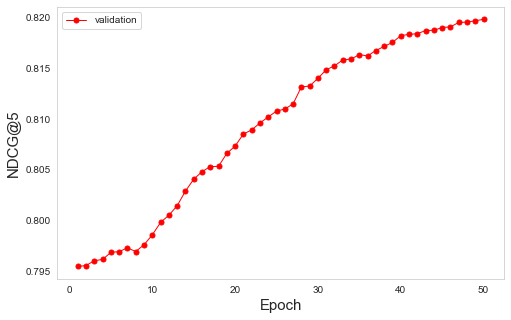

In [26]:
model = RankNet(size_0, size_1, size_2)

ndcg_train_log, ndcg_test_log = model.train(
    train_df_selected, test_df_selected, size_mini_batch, alpha, n_epoch, learning_rate, k
)

fig, ax = plt.subplots(figsize=(8, 5))        
plt.plot(
    np.arange(n_epoch) + 1, ndcg_test_log, 'r-',
    linewidth=1, marker='o', markersize=5, label='validation'
)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel(f'NDCG@{k}', fontsize=15)
plt.legend()
plt.grid()
plt.show()